# Preparation

In [ ]:
# @title Import requirements

!pip install 'pymongo[srv]'

import os
import textwrap
import pandas as pd

from google.colab import userdata, drive
from pymongo import MongoClient
from collections import Counter


from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
# @title Connect to MongoDB

client = MongoClient(userdata.get("mongoUri"))

db = client["goats"]
preprocessed = db["preprocessed"]
preprocessed_temp = db["preprocessed_temp"]
analyzed = db["analyzed"]
tokenized = db["tokenized"]

# Labeling

In [ ]:
# @title Understanding preprocessed data

preprocessed_df = pd.DataFrame(preprocessed.find())
preprocessed_df.head()

In [ ]:
# @title Count labeled and unlabeled data
from collections import Counter

sentiment_docs = preprocessed.find()
label_counter = Counter()
total_sentiments = 0

for doc in sentiment_docs:
    if 'label' in doc:
        label_counter[doc['label']] += 1

for label, count in label_counter.items():
    print(f"Label: {label}, Count: {count}")
    total_sentiments += count

print(f"Total Sentiments : {total_sentiments}")


Label: messi, Count: 506
Label: ronaldo, Count: 505
Label: neutral, Count: 504
Label: None, Count: 16767
Total Sentiments : 18282


In [ ]:
#@title Selecting relevant data

query_criteria = {
    "text" : {
        "$regex" : "piala dunia|pildun|wc|world|cup",
        "$options" : "i"
    },
    "label": None
}

unlabelled_sentiments = preprocessed.find(query_criteria).sort({"_id": 1}).skip(100)
total_count = preprocessed.count_documents(query_criteria)

print("Total number of unlabelled sentiments:", total_count)

In [ ]:


# @title Data Labeling
import textwrap
import os

label_mapping = {
    "0": "neutral",
    "1": "ronaldo",
    "2": "messi",
    "s": "skip",
    "d": "delete",
    "q": "quit"
}

YELLOW = "\033[93m"
BOLD = "\033[1m"
NORMAL = "\033[0m"

for sentiment in unlabelled_sentiments:
  wrapped_text = textwrap.fill(sentiment["text"], width=70)
  print(YELLOW + BOLD + "Text: ")
  print(wrapped_text + NORMAL)

  print("(0: neutral, 1: ronaldo, 2: messi, s: skip, d: delete, q: quit)")
  label_input = input("Enter option: ")
  if label_input.lower() == "q":
    break
  elif label_input.lower() == "s":
    print("Sentiment skipped")
    continue
  elif label_input.lower() == "d":
    preprocessed.delete_one({"_id": sentiment["_id"]})
    print("Sentiment deleted")
  elif label_input == "0" or label_input == "1" or label_input == "2":
    label = label_mapping.get(label_input)
    preprocessed.update_one({"_id": sentiment["_id"]}, {"$set": {"label": label}})
    print("Label added successfully:", label)
  else:
    print("Invalid label. Skipping this document.")
    continue
  print()

print("Labelling process completed.")

# Analytics

## Data Preparation

In [ ]:
# @title Separating labeled and unlabeled data

dataset = pd.DataFrame(preprocessed.find())

x = dataset['text']
y = dataset['label']

labeled_indices = dataset['label'].notnull()
x_labeled = x[labeled_indices]
y_labeled = y[labeled_indices]

unlabeled_indices = dataset['label'].isnull()
x_unlabeled = x[unlabeled_indices]
y_unlabeled = y[unlabeled_indices]

# print(x_labeled, y_labeled)

In [ ]:
# @title Data mapping

label_mapping = {
    "neutral": 0,
    "ronaldo": 1,
    "messi": 2
}

y_labeled = y_labeled.map(label_mapping)

In [ ]:
# @title Spliting into data data train and data test

x_train = x_labeled
y_train = y_labeled

x_test = x_unlabeled
y_test = y_unlabeled

In [ ]:
print(f"Train set size: {len(x_train)}")
print(f"Test set size: {len(x_test)}")

print("\nTrain set:")
print(pd.DataFrame({'text': x_train, 'label': y_train}))

print("\nTest set:")
print(pd.DataFrame({'text': x_test, 'label': y_test}))

In [ ]:
# @title Extract text into vector

vectorizer = CountVectorizer()

x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

In [ ]:
print(x_train_vectorized.toarray())
print(x_test_vectorized.toarray())

## Modelling

In [ ]:
# @title Train model

naive_bayes = MultinomialNB()
naive_bayes.fit(x_train_vectorized, y_train)

MultinomialNB()

In [ ]:
# @title Evaluate the model

y_train_predict = naive_bayes.predict(x_train_vectorized)
y_train_predict_proba = naive_bayes.predict_proba(x_train_vectorized)

accuracy = accuracy_score(y_train, y_train_predict)
classification = classification_report(y_train, y_train_predict, target_names = ["neutral","ronaldo","messi"])

train_df = pd.DataFrame({
    'text': x_labeled,
    'label': y_train,
    'predicted_label': y_train_predict,
    'neutral_probability': y_train_predict_proba[:, 0].round(3),
    'ronaldo_probability': y_train_predict_proba[:, 1].round(3),
    'messi_probability': y_train_predict_proba[:, 2].round(3),
    'reliability_score': y_train_predict_proba.max(axis=1).round(3)
})

print(f"Accuration            : {accuracy*100:.2f}%\n")
print(f"Classification Report :\n{classification}")

train_df.head()

## Classification

In [ ]:
# @title Classify sentiments

y_predict = naive_bayes.predict(x_test_vectorized)
y_predict_proba = naive_bayes.predict_proba(x_test_vectorized)

print(y_predict)
predicted_df = pd.DataFrame({
    'text': x_unlabeled,
    'label': y_predict,
    'neutral_probability': y_predict_proba[:, 0].round(3),
    'ronaldo_probability': y_predict_proba[:, 1].round(3),
    'messi_probability': y_predict_proba[:, 2].round(3),
    'reliability_score': y_predict_proba.max(axis=1).round(3)
})

print("\nlabeled set with predictions and reliability scores:")
predicted_df.head(1000)

In [ ]:
# @title Combined Dataframes

combined_df = pd.concat([train_df[['text', 'label', 'neutral_probability', 'ronaldo_probability', 'messi_probability', 'reliability_score' ]],
                         predicted_df[['text', 'label', 'neutral_probability', 'ronaldo_probability', 'messi_probability', 'reliability_score']]],
                        ignore_index=True)

combined_df.head(1000)

In [ ]:
# @title Data mapping

label_mapping = {
    0 : "neutral",
    1 : "ronaldo",
    2 : "messi"
}

combined_df['label'] = combined_df['label'].map(label_mapping)
combined_df.head(1000)

In [ ]:
# @title Delete Analyzed Collection If Needed
delete_result = tokenized.delete_many({})

print(f"Deleted {delete_result.deleted_count} documents from the collection.")

Deleted 218282 documents from the collection.


In [ ]:
# @title Storing analyzed result to MongoDB Collection

analyzed_result = combined_df.to_dict("records")
analyzed.insert_many(analyzed_result)

# Visualization

Neutral tweets: 4235
Ronaldo tweets: 6947
Messi tweets: 7100


<ipython-input-85-71b281495e00>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predicted_df['label'], palette='viridis', order=[0, 1, 2])


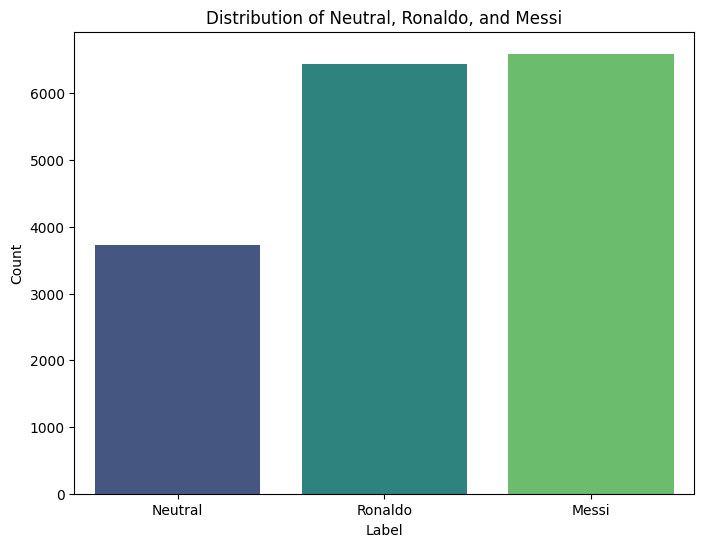

In [ ]:
# @title Bar Chart

label_counts = combined_df['label'].value_counts()

print(f"Neutral tweets: {label_counts['neutral']}")
print(f"Ronaldo tweets: {label_counts['ronaldo']}")
print(f"Messi tweets: {label_counts['messi']}")

plt.figure(figsize=(8, 6))
sns.countplot(x=predicted_df['label'], palette='viridis', order=[0, 1, 2])
plt.title('Distribution of Neutral, Ronaldo, and Messi')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Neutral', 'Ronaldo', 'Messi'])
plt.show()

In [ ]:
# @title Download NLTK Resources

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

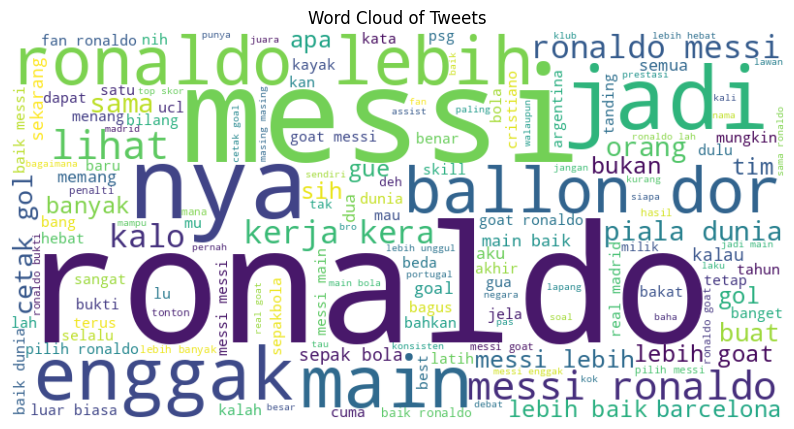

In [ ]:
# @title Word Cloud

text_data = ' '.join(combined_df['text'])
stop_words = set(stopwords.words('english'))
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, max_words=150, colormap='viridis').generate(text_data)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()
